#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

## Подготовка

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from timeit import default_timer as timer

Создадим функцию для быстрого анализа таблицы

In [3]:
def df_info(dataframe):
    column = dataframe.columns.values.tolist() # список наименований столбцов таблицы
    print('Общая информация о таблице:\n')
    dataframe.info() # общая иноформация о таблице
    print('\nВнешний вид таблицы:')
    display(dataframe.head()) # внешний вид первых 5 строк таблицы

    # далее выводим все интересующие нас особенности таблицы, соответствнно, обозначенные в функции print()
    print('Столбцы таблицы: {}\n'.format(column),
          '\n\nОбщее количество уникальных значений столбцов {}:\n\n{}'.
          format(column, dataframe.nunique()),
          '\n\nКоличество пропущенных значений столбцов {}:\n\n{}'.
          format(column, dataframe.isna().sum()))
    
    for i in column: # создадим цикл для перебора значений столбцов для отдельного примнения к ним любой функции
          print('\n\nКоличество дубликатов столбца:\n{}\t   {}'.format(i, dataframe[i].duplicated().sum()))
    print('\nОбщее количество явных дубликтов: {}'.format(dataframe.duplicated().sum()))
    print('\n\nТаблица корреляций значений столбцов {}:\n\n{}'.format(column, dataframe.corr()), '\n',
          '\n\nТаблица распределений значений столбцов {}:\n\n{}'.format(column, dataframe.describe()), '\n')
    print('Гистограммы распределений значений столбцов {}'.format(column))
    dataframe.hist(bins=100, figsize=(15, 7), edgecolor = 'k')

Константная переменная

In [4]:
RS = 12345

Загрузим данные с учетом создания временных индексов

In [5]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

Получим первичную информацию о данных

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Внешний вид таблицы:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Столбцы таблицы: ['num_orders']
 

Общее количество уникальных значений столбцов ['num_orders']:

num_orders    81
dtype: int64 

Количество пропущенных значений столбцов ['num_orders']:

num_orders    0
dtype: int64


Количество дубликатов столбца:
num_orders	   26415

Общее количество явных дубликтов: 26415


Таблица корреляций значений столбцов ['num_orders']:

            num_orders
num_orders         1.0 
 

Таблица распределений значений столбцов ['num_orders']:

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000 

Гистограммы распределений значений столбцов ['num_orders']


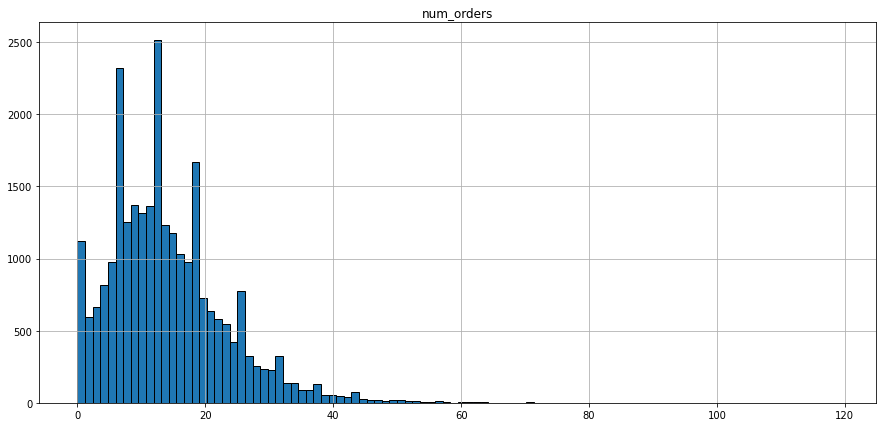

In [6]:
df_info(df)

Проведем ресемплинг по одному часу

In [7]:
df = df.resample('1h').sum()

Посмотрим, какой вид таблицы получился

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проверим теперь на пропуски, на всякий случай


In [9]:
df.isna().sum()

num_orders    0
dtype: int64

И посмотрим гистограмму распределения

array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

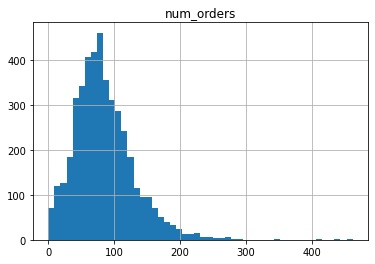

In [10]:
df.hist(bins=50)


In [11]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

**Выводы**: провели ресемплинг по часу, вышло распределение нормальное, можно дальше вести работу с данными.

## Анализ

Построим графики полученной таблицы, посмотрим их тренды и сезонность

<AxesSubplot:xlabel='datetime'>

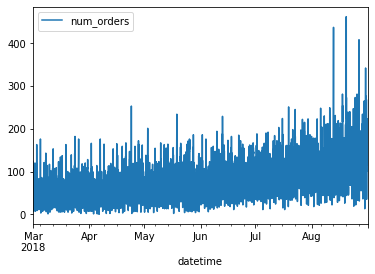

In [12]:
df.plot()

<AxesSubplot:xlabel='datetime'>

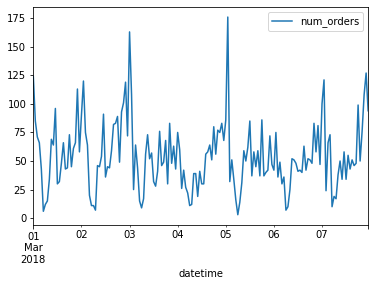

In [13]:
df.head(24*7).plot()


<AxesSubplot:title={'center':'Trend'}, xlabel='datetime'>

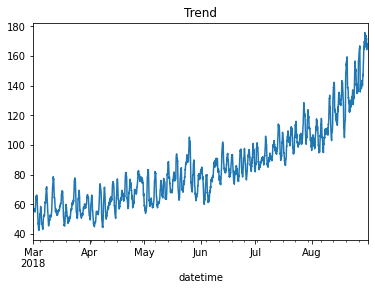

In [14]:
decomposed_df = seasonal_decompose(df)
decomposed_df.trend.plot(title='Trend')

<AxesSubplot:title={'center':'Seasonal'}, xlabel='datetime'>

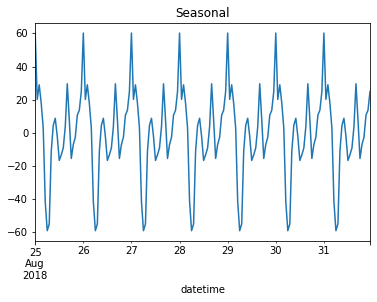

In [15]:
decomposed_df.seasonal.tail(24*7).plot(title='Seasonal')

<AxesSubplot:title={'center':'Resid'}, xlabel='datetime'>

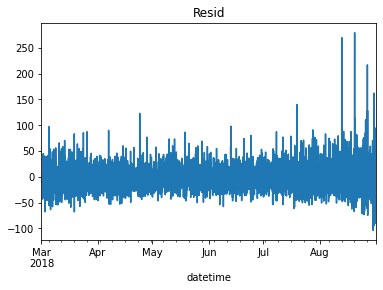

In [16]:
decomposed_df.resid.plot(title='Resid')

**Выводы:** можно отметить дневную сезонность с восходящим трендом по заказам такси


## Обучение

Приступим к созданию данных со скользящими средними. Воспользуемся созданной функцией.

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df_features = df.copy()
    df_features['year'] = df_features.index.year
    df_features['month'] = df_features.index.month
    df_features['day'] = df_features.index.day
    df_features['dayofweek'] = df_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_features['lag_{}'.format(lag)] = df_features['num_orders'].shift(lag)

    df_features['rolling_mean'] = df_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    df_features = df_features.dropna()
    return df_features

Собственно случайным образом подберем количество отстающих значений значений и количество средних значений

In [18]:
df_features = make_features(df, 48, 21)

Просмотрим таблицу

In [19]:
df_features.head(10)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,2018,3,3,5,72.0,119.0,101.0,93.0,49.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.142857
2018-03-03 01:00:00,108,2018,3,3,5,163.0,72.0,119.0,101.0,93.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,62.857143
2018-03-03 02:00:00,25,2018,3,3,5,108.0,163.0,72.0,119.0,101.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,67.047619
2018-03-03 03:00:00,64,2018,3,3,5,25.0,108.0,163.0,72.0,119.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,67.714286
2018-03-03 04:00:00,44,2018,3,3,5,64.0,25.0,108.0,163.0,72.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,70.238095
2018-03-03 05:00:00,15,2018,3,3,5,44.0,64.0,25.0,108.0,163.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,72.000000
2018-03-03 06:00:00,9,2018,3,3,5,15.0,44.0,64.0,25.0,108.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,70.523810
2018-03-03 07:00:00,17,2018,3,3,5,9.0,15.0,44.0,64.0,25.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,68.809524
2018-03-03 08:00:00,56,2018,3,3,5,17.0,9.0,15.0,44.0,64.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,67.047619


Создадим функцию измерения значения RMSE

In [20]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

rmse = make_scorer(root_mean_squared_error, greater_is_better=False)

Разделим выборку на обучающую и тестовую

In [21]:
train, test = train_test_split(df_features, shuffle=False, test_size=0.1)
train = train.dropna()

Просмотрим как выглядит трэйн

In [22]:
train.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,2018,3,3,5,72.0,119.0,101.0,93.0,49.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.142857
2018-03-03 01:00:00,108,2018,3,3,5,163.0,72.0,119.0,101.0,93.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,62.857143
2018-03-03 02:00:00,25,2018,3,3,5,108.0,163.0,72.0,119.0,101.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,67.047619
2018-03-03 03:00:00,64,2018,3,3,5,25.0,108.0,163.0,72.0,119.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,67.714286
2018-03-03 04:00:00,44,2018,3,3,5,64.0,25.0,108.0,163.0,72.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,70.238095


Выделим целевой признак и тренировочные признаки

In [23]:
target_train = train['num_orders']
target_test = test['num_orders']
features_train = train.drop(['num_orders', 'year'], axis=1)
features_test = test.drop(['num_orders','year'], axis=1)

In [24]:
target_train.head()

datetime
2018-03-03 00:00:00    163
2018-03-03 01:00:00    108
2018-03-03 02:00:00     25
2018-03-03 03:00:00     64
2018-03-03 04:00:00     44
Freq: H, Name: num_orders, dtype: int64

In [25]:
features_train.head()

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,3,3,5,72.0,119.0,101.0,93.0,49.0,89.0,83.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.142857
2018-03-03 01:00:00,3,3,5,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,62.857143
2018-03-03 02:00:00,3,3,5,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,67.047619
2018-03-03 03:00:00,3,3,5,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,67.714286
2018-03-03 04:00:00,3,3,5,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,70.238095


**Выводы**: данные подготовлены для обучения моделям

### Приступим к обучению моделей

**Модель LinearRegression**

In [26]:
model_lr = LinearRegression()

Создадим таблицу гиперпараметров

In [27]:
params_lr = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [28]:
tscv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=1000,
    test_size=100)

Применим метод `GridSearchCV` для поиска гиперпараметров

In [29]:
clf_lr = GridSearchCV(model_lr, params_lr, scoring=rmse, verbose=True, cv=tscv, n_jobs=-1)
clf_lr.fit(features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=1000, n_splits=5, test_size=100),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False),
             verbose=True)

In [30]:
print('Лучшие гиперпараметры для модели LinearRegression:', clf_lr.best_params_)

Лучшие гиперпараметры для модели LinearRegression: {'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [31]:
best_params_lr = clf_lr.best_params_

Теперь обучим нашу модель с учетом подобранных гиперпараметров, а также замерим время выполнения каждой операции обучения и предсказания

In [32]:
model_lr = LinearRegression(**best_params_lr)

start = timer()

model_lr.fit(features_train, target_train)

end = timer()
time_lr_fit = end - start

Предскажем результаты на обучающей выборке

In [33]:
start = timer()

pred_lr_train = model_lr.predict(features_train)

end = timer()
time_lr_pred = end - start
print("Значение метрики RMSE модели LinearRegression обучающей выборки:", np.sqrt(mse(target_train, pred_lr_train)))

Значение метрики RMSE модели LinearRegression обучающей выборки: 23.356573650874548


**Модель LGBMRegressor**

Применим тот же алгоритм обучения и подобора гиперпараметров, что и выше, дополнительно подготовив обучающие признаки для внутренней обработки модели

In [34]:
features_train_lgb = features_train.copy()
features_test_lgb = features_test.copy()

Выделим отдельно список признаков, которые также пригодятся нам для других моделей

In [35]:
cat_features = features_train.columns[np.where(features_train.dtypes != float)].values.tolist()

In [36]:
for header in cat_features:
    features_train_lgb[header] = features_train_lgb[header].astype('category')
    features_test_lgb[header] = features_test_lgb[header].astype('category')

In [37]:
model_lgb = LGBMRegressor(random_state=RS)

In [38]:
params_lgb = {
    'n_estimators': [400, 700],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,25],
    'num_leaves': [50, 100],
    'reg_alpha': [1.1, 1.3],
    'reg_lambda': [1.1, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.9],
    'subsample_freq': [20],
    'metric': ['rmse']
}

In [40]:
best_params_lgb = {'colsample_bytree': 0.7, 
                   'max_depth': 15, 
                   'metric': 'rmse', 
                   'min_split_gain': 0.4, 
                   'n_estimators': 400, 
                   'num_leaves': 100, 
                   'reg_alpha': 1.1, 
                   'reg_lambda': 1.3, 
                   'subsample': 0.9,
                   'subsample_freq': 20}

In [41]:
model_lgb = LGBMRegressor(random_state=RS, **best_params_lgb)
start = timer()

model_lgb.fit(features_train_lgb, target_train)

end = timer()
time_lgb_fit = end - start

In [42]:
start = timer()

pred_lgb_train = model_lgb.predict(features_train_lgb)

end = timer()
time_lgb_pred = end - start

rmse_lgb_train = (root_mean_squared_error(target_train, pred_lgb_train))
print('Значение метрики RMSE модели LGBMRegressor обучающей выборки:', rmse_lgb_train)

Значение метрики RMSE модели LGBMRegressor обучающей выборки: 1.218247482287069


**Модель CatBoostRegressor**

In [43]:
model_cat = CatBoostRegressor(random_state=RS)

In [44]:
params_cat = {'depth':[3, 10, 15],
              'iterations':[10, 20, 50],
              'learning_rate':[0.03, 0.3, 0.7], 
              'l2_leaf_reg':[3, 10],
              'border_count':[5, 10]}

In [45]:
clf_cat = GridSearchCV(estimator=model_cat, param_grid = params_cat, scoring=rmse, cv=tscv, n_jobs=-1)
clf_cat.fit(features_train, target_train, cat_features=cat_features)

0:	learn: 34.0133278	total: 311ms	remaining: 2.8s
1:	learn: 33.7003323	total: 312ms	remaining: 1.25s
2:	learn: 33.4427381	total: 313ms	remaining: 730ms
3:	learn: 33.2436382	total: 314ms	remaining: 471ms
4:	learn: 32.9859971	total: 315ms	remaining: 315ms
5:	learn: 32.7620252	total: 315ms	remaining: 210ms
6:	learn: 32.5076747	total: 316ms	remaining: 136ms
7:	learn: 32.2760748	total: 317ms	remaining: 79.3ms
8:	learn: 32.0581946	total: 318ms	remaining: 35.3ms
9:	learn: 31.8592391	total: 319ms	remaining: 0us
0:	learn: 34.2763445	total: 961us	remaining: 8.65ms
1:	learn: 33.9509604	total: 1.91ms	remaining: 7.65ms
2:	learn: 33.6822973	total: 2.81ms	remaining: 6.55ms
3:	learn: 33.4739580	total: 3.68ms	remaining: 5.52ms
4:	learn: 33.1832135	total: 4.68ms	remaining: 4.68ms
5:	learn: 32.9507538	total: 5.6ms	remaining: 3.73ms
6:	learn: 32.7178011	total: 6.4ms	remaining: 2.74ms
7:	learn: 32.4765320	total: 7.19ms	remaining: 1.8ms
8:	learn: 32.2265031	total: 7.94ms	remaining: 882us
9:	learn: 32.008816

GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=1000, n_splits=5, test_size=100),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fcb2716c400>,
             n_jobs=-1,
             param_grid={'border_count': [5, 10], 'depth': [3, 10, 15],
                         'iterations': [10, 20, 50], 'l2_leaf_reg': [3, 10],
                         'learning_rate': [0.03, 0.3, 0.7]},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False))

In [46]:
print('Лучшие гиперпараметры для модели CatBoost Regressor:', clf_cat.best_params_)

Лучшие гиперпараметры для модели CatBoost Regressor: {'border_count': 5, 'depth': 3, 'iterations': 50, 'l2_leaf_reg': 3, 'learning_rate': 0.3}


In [47]:
best_params_cat = clf_cat.best_params_

In [48]:
model_cat = CatBoostRegressor(random_state=RS, loss_function="RMSE", **best_params_cat)

start = timer()

model_cat.fit(features_train, target_train, cat_features=cat_features,  verbose=10)

end = timer()
time_cat_fit = end - start

0:	learn: 34.4281962	total: 1.84ms	remaining: 90.1ms
10:	learn: 24.9583227	total: 15.3ms	remaining: 54.4ms
20:	learn: 23.9948738	total: 28.3ms	remaining: 39.1ms
30:	learn: 23.3085800	total: 47.9ms	remaining: 29.4ms
40:	learn: 22.5906992	total: 62.6ms	remaining: 13.7ms
49:	learn: 22.1610638	total: 77.1ms	remaining: 0us


In [49]:
start = timer()

pred_cat_train = model_cat.predict(features_train)

end = timer()
time_cat_pred = end - start

In [50]:
rmse_cat_train = (root_mean_squared_error(target_train, pred_cat_train))
print('Значение метрики RMSE модели LGBMRegressor:', rmse_cat_train)

Значение метрики RMSE модели LGBMRegressor: 22.118784493622478


## Тестирование

Теперь же проверим полученные модели на тестовой выборке

In [51]:
start = timer()

pred_lr_test = model_lr.predict(features_test)

end = timer()
time_lr_pred_test = end - start

rmse_lr_test = root_mean_squared_error(target_test, pred_lr_test)
print("Значение метрики RMSE модели LinearRegression: ", root_mean_squared_error(target_test, pred_lr_test))

Значение метрики RMSE модели LinearRegression:  42.83130940064029


In [52]:
start = timer()

pred_lgb_test = model_lgb.predict(features_test_lgb)

end = timer()
time_lgb_pred_test = end - start

rmse_lgb_test = root_mean_squared_error(target_test, pred_lgb_test)
print('Значение метрики RMSE модели LGBMRegressor:', rmse_lgb_test)

Значение метрики RMSE модели LGBMRegressor: 40.48321307666306


In [53]:
start = timer()

pred_cat = model_cat.predict(features_test)

end = timer()
time_cat_pred_test = end - start

rmse_cat_test = root_mean_squared_error(target_test, pred_cat)
print('Значение метрики RMSE модели CatBoostRegressor:', rmse_cat_test)

Значение метрики RMSE модели CatBoostRegressor: 45.785239327135415


Сведем результаты в одну таблицу для удобства

In [54]:
# создаем таблицу, в которую занесем значения AUC-ROC различных лучших моделей
final_score_table = pd.DataFrame({'Модели': ['LinearRegression', 'LGBMRegressor', 'CatBoostRegressor'],
                                  'Значение RMSE':         [rmse_lr_test, rmse_lgb_test, rmse_cat_test],
                                  'Время обучения, с':     [time_lr_fit, 
                                                            time_lgb_fit, 
                                                            time_cat_fit],
                                  'Скорость предсказания': [time_lr_pred_test, 
                                                            time_lgb_pred_test,
                                                            time_cat_pred_test],
                                  'Параметры модели':      [best_params_lr, 
                                                            best_params_lgb, 
                                                            best_params_cat]}).sort_values(
                               by='Значение RMSE').reset_index(drop=True)

# обозначим лучший результат и сохраним его в переменную
best_rmse_result = final_score_table['Значение RMSE'].min()

# выведем таблицу и вывод на экран
display('Таблица значений RMSE для различных моделей', final_score_table)
print('Лучший результат у модели {} со значением RMSE: {}. \nВремя обучения: {}. \
\nСкорость предсказания: {}.\n\nЛучшие параметры модели {}:'.
      format(final_score_table['Модели'][0], round(best_rmse_result, 3), 
             final_score_table['Время обучения, с'][0], 
             final_score_table['Скорость предсказания'][0],
             final_score_table['Модели'][0]))
display(final_score_table['Параметры модели'][0])

'Таблица значений RMSE для различных моделей'

,Модели,Значение RMSE,"Время обучения, с",Скорость предсказания,Параметры модели
0,LGBMRegressor,40.483213,1617.608138,0.154861,"{'colsample_bytree': 0.7, 'max_depth': 15, 'me..."
1,LinearRegression,42.831309,0.007462,0.003295,"{'copy_X': True, 'fit_intercept': False, 'norm..."
2,CatBoostRegressor,45.785239,0.461357,0.003961,"{'border_count': 5, 'depth': 3, 'iterations': ..."


Лучший результат у модели LGBMRegressor со значением RMSE: 40.483. 
Время обучения: 1617.6081378599629. 
Скорость предсказания: 0.15486076404340565.

Лучшие параметры модели LGBMRegressor:


{'colsample_bytree': 0.7,
 'max_depth': 15,
 'metric': 'rmse',
 'min_split_gain': 0.4,
 'n_estimators': 400,
 'num_leaves': 100,
 'reg_alpha': 1.1,
 'reg_lambda': 1.3,
 'subsample': 0.9,
 'subsample_freq': 20}

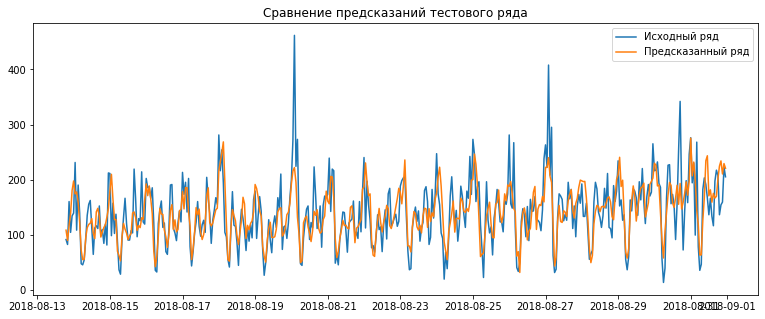

In [55]:
plt.figure(figsize=(13, 5))

plt.plot(target_test, label='Исходный ряд')
plt.plot(target_test.index, pred_lgb_test, label='Предсказанный ряд')

plt.title('Сравнение предсказаний тестового ряда')
plt.legend()
plt.show()

Как видим, совпадение презсказанных значений с исходными тестовыми достаточно хорошее, однако пиковые значения исходных рядов не учтены в предсказаных.

# Общие выводы

В ходе работы были:
- просмотренны данные исходной таблицы;
- проведено ресемплирование по часу;
- проверены и удалены пропуски;
- отобранны необходимые признаки;
- признаки разделены на обучающую и тестовую выборки
- создана функция для получения скользящих признаков
- случайным образом выбрано их количество. 

Обучены три модели машинного обучения: 
- LinearRegressor
- LGBMRegressor
- CatBoostRegressor

Для каждой модели найдены лучшие гиперпараметры с помощью модуля `GridSearchCV`, которые сохранены в соответствующие переменные.

В ходе работы получены следующие результаты:

Наиболее точной моделью является модель `LGBMRegressor` для которой:
- значение метрики RMSE равное 40.48;
- время обучения модели: 1617 с;
- скорость предсказания модели:  0.01 с.

Более быстрая скорость обучения и предсказания у модели `LinearRegressor`: 0.006 с и 0.002 с соответсвенно. К тому же  несущественно хуже точность предсказания (RMSE: 42.83)

Чуть менее точной является модель `CatBoostRegressor`: RMSE = 45.78, время обучения	- 0.72 с, скорость предсказания - 0.006 с.